## Execute imports

In [78]:
%matplotlib inline

In [79]:
import seaborn as sns

## Read Data Files

In [2]:
# imports & constants
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150


MAX_VALS = 4*24*7 # 4 measurements per hour, 24 hours in a day
PATH_PREFIX = os.path.join(".", "dataset_live")
DATASET_ORIGINAL = os.path.join(PATH_PREFIX, "original")
DATASET_EXPANDED = os.path.join(PATH_PREFIX, "expanded")

ori_data = {
    "load_energy_meter": os.path.join(DATASET_ORIGINAL, "load_pwr.csv"),
    "common_services": os.path.join(DATASET_ORIGINAL, "cserv_pwr.csv"),
    "pv_generation": os.path.join(DATASET_ORIGINAL, "pv_pwr.csv"),
    "meters_index": os.path.join(DATASET_ORIGINAL, "dataset_index.csv"),
    "support": os.path.join(PATH_PREFIX, "HackTheElectron dataset support data.xlsx")
}

exp_data = {
    "load_energy_meter": os.path.join(DATASET_EXPANDED, "load_pwr.csv"),
    "common_services": os.path.join(DATASET_EXPANDED, "cserv_pwr.csv"),
    "pv_generation": os.path.join(DATASET_EXPANDED, "pv_pwr.csv"),
    "meters_index": os.path.join(DATASET_EXPANDED, "dataset_index.csv"),
    "building": os.path.join(DATASET_EXPANDED, "building_type.csv"),
    "tariffs": os.path.join(DATASET_EXPANDED, "tariffs.csv"),
    "support": os.path.join(PATH_PREFIX, "HackTheElectron dataset support data.xlsx")
}


# The original Dataset

In [3]:
# reading original data

df_dataset_index = pd.read_csv(ori_data['meters_index'],sep=';', encoding="latin1")
df_load = pd.read_csv(ori_data['load_energy_meter'],sep=';')
df_load = df_load.drop(columns="Unnamed: 0") # dropping meter ID (??)
df_load["time_datetime"]=pd.to_datetime(df_load.Time)
df_load = df_load.sort_values("time_datetime")


columns_of_interest = list(df_load.columns)
columns_of_interest.remove("Time")
columns_of_interest.remove("time_datetime")
for column_meter in columns_of_interest:
    # transforming from W to kWh
    df_load[column_meter] = df_load[column_meter]/4
    values = np.array(df_load[column_meter])
    mean, std = np.mean(values[:MAX_VALS]), np.std(values[:MAX_VALS])
    # z-nromalizing
    df_load[column_meter] = (df_load[column_meter] - mean) / std
    
    

# df_load.head()
# df_dataset_index.head()

c:\users\m\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


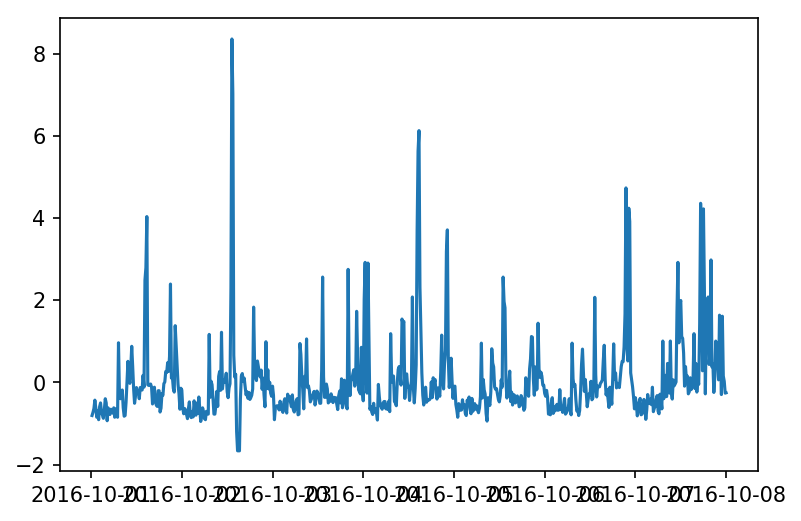

In [4]:
# testing with one meter data


x=df_load[["time_datetime"]][:MAX_VALS].values

y=df_load[["meter_1"]][:MAX_VALS].values

plt.plot(x,y)


# next steps

# z-normalize time series (all of them, and keep record of mean/var)

# experimenting with sax hehe



# The Expanded Dataset

In order to make it easier to process information, we have used Excel formulas to pre-parse the original dataset, the changes include:
* Created additional csv files with the information from the explanation sheet
* Trimmed DAY, MONTH, HOUR, MINUTE info
* Added DayOfWeek, season and daylight-time info

## Read the Expanded Solar Production

In [5]:
df_pv_generation = pd.read_csv(exp_data['pv_generation'],sep=',')
# df_pv_generation = df_load.drop(columns="Unnamed: 0") # dropping meter ID (??)
df_pv_generation["date_datetime"]=pd.to_datetime(df_pv_generation.Date)
df_pv_generation = df_pv_generation.sort_values("date_datetime")

## Average production in time

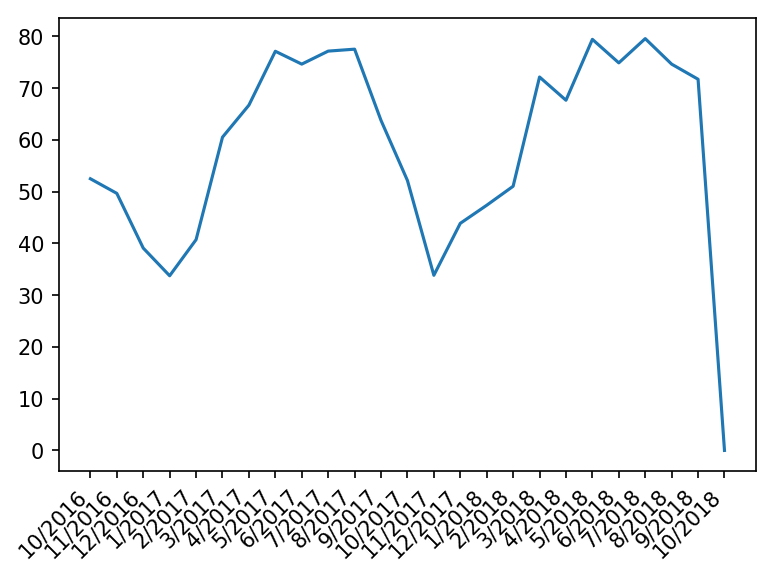

In [6]:
# calculate the number of months in the dataset
months_code = {}
generation_per_month_indexes = {}
generated_load = {}

i = 0
for month in df_pv_generation.Month:
    year = df_pv_generation.Year[i]
    code = str(month) + '/'+ str(year)
    months_code[code] = []
    if not code in generation_per_month_indexes:
        generation_per_month_indexes[code] = []
    if not code in generated_load:
        generated_load[code] = []
    generation_per_month_indexes[code].append(i)
    i += 1
    
for month in months_code:
    values = df_pv_generation.EPV[generation_per_month_indexes[month]]
    generated_load[month] = np.mean(values)

x=list(generated_load.keys())
y=list(generated_load.values())
plt.xticks(rotation=45, ha='right')
plt.plot(x,y)

## Average production comparison between same period in multiple years

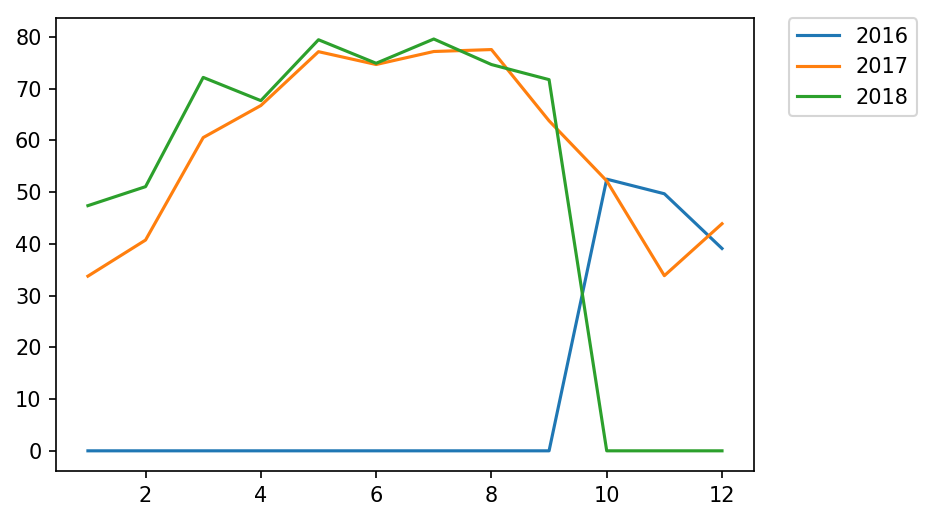

In [7]:
# calculate the number of months in the dataset
months_code = {}
generation_per_month_indexes = {}
generated_load = {}

i = 0
for month in df_pv_generation.Month:
    year = df_pv_generation.Year[i]
    code = str(month) + '/'+ str(year)
    months_code[code] = []
    if not code in generation_per_month_indexes:
        generation_per_month_indexes[code] = []
    if not code in generated_load:
        generated_load[code] = []
    generation_per_month_indexes[code].append(i)
    i += 1
    
for month in months_code:
    values = df_pv_generation.EPV[generation_per_month_indexes[month]]
    generated_load[month] = np.mean(values)

# separate plot sets from coded mont-year
months = []
years = []
for code in months_code:
    month, year = code.split("/")
    months.append(int(month))
    years.append(int(year))

x = np.unique(months)
x = np.sort(x)
years = np.unique(years)

year_load = {}
for code in months_code:
    month, year = code.split("/")
    month = int(month)
    year = int(year)
    if not year in year_load:
        year_load[year] = {}
    year_load[year][month] = generated_load[code]

# fill the missing months with zero and sort
for year in year_load.keys():
    for m in range(12):
        month = m + 1
        if not month in year_load[year]:
            year_load[year][month] = 0
    ordered = {}
    for key in sorted(year_load[year]):
        ordered[key] =  year_load[year][key]
    year_load[year] = ordered

i = 0
for year in years:
    y = list(year_load[year].values())
    plt.plot(x, y, label=year)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    i += 1 

plt.show()

## Average production aggregated by month 

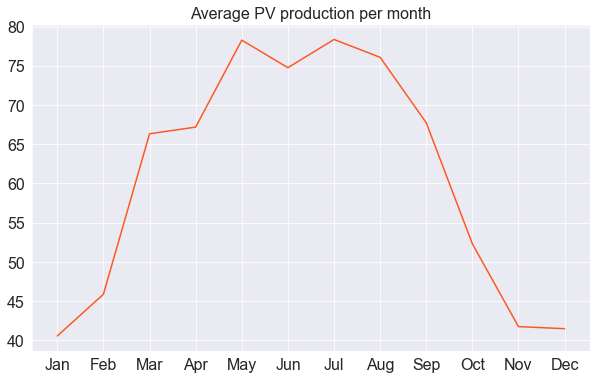

In [95]:
generation_per_month_indexes = {}
generated_load = {}

for month in range(12):
    generation_per_month_indexes[month + 1] = []
    generated_load[month + 1] = []
i = 0
for month in df_pv_generation.Month:
    generation_per_month_indexes[month].append(i)
    i += 1
for month in range(12):
    values = df_pv_generation.EPV[generation_per_month_indexes[month + 1]]
    generated_load[month + 1] = np.mean(values)
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
x=list(generated_load.keys())
y=list(generated_load.values())
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
plt.plot(MONTHS,y, c="#FF5722")
plt.title("Average PV production per month", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.xticks(MONTHS)
plt.show()

In [69]:
x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

## Average production aggregated by hour

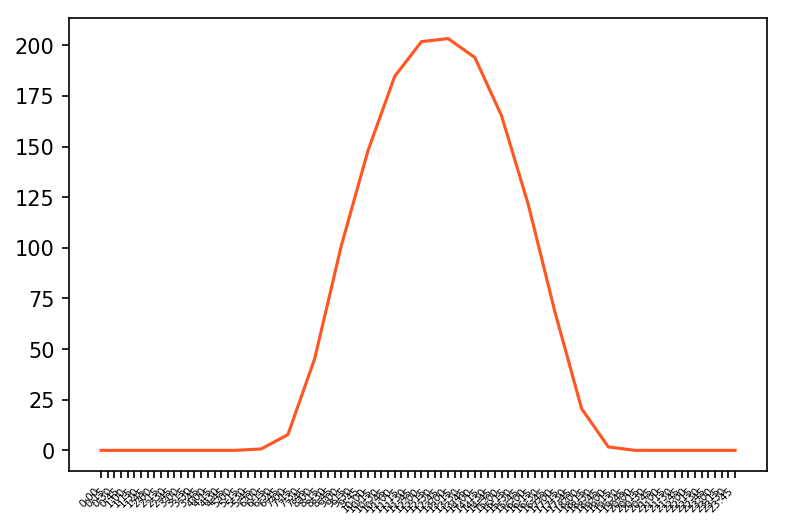

In [76]:
generation_per_hour_indexes = {}
generated_load = {}

i = 0
for hour in df_pv_generation.Hora:
    if not hour in generation_per_hour_indexes:
        generation_per_hour_indexes[hour] = []
    generation_per_hour_indexes[hour].append(i)
    i += 1

for hour in list(generation_per_hour_indexes.keys()):
    values = df_pv_generation.EPV[generation_per_hour_indexes[hour]]
    generated_load[hour] = np.mean(values)

x=list(generated_load.keys())
y=list(generated_load.values())
plt.xticks(fontsize=5, rotation=45, ha='right')
plt.plot(x,y,c="#FF5722");
plt.show()

## Average prduction aggregated by hour - month

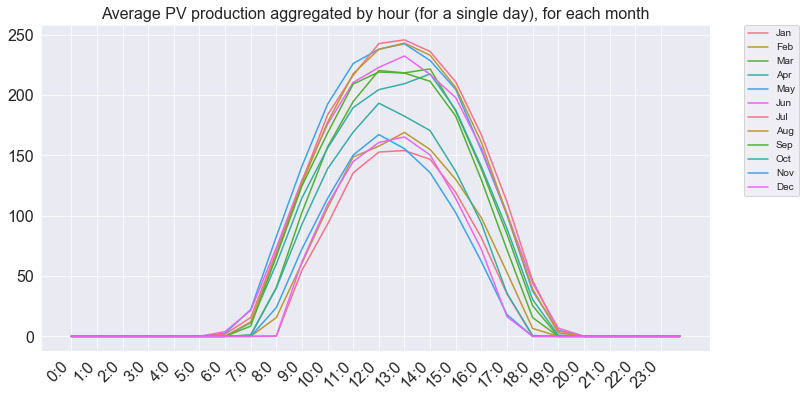

In [94]:
generation_per_hour_indexes = {}
generated_load = {}
hour_month_code = {}
    
i = 0
for hour in df_pv_generation.Hora:
    month = df_pv_generation.Month[i]
    hour_month_code = str(month) + '-' + str(hour)
    if not hour_month_code in generation_per_hour_indexes:
        generation_per_hour_indexes[hour_month_code] = []
    generation_per_hour_indexes[hour_month_code].append(i)
    i += 1

for hour_code in list(generation_per_hour_indexes.keys()):
    values = df_pv_generation.EPV[generation_per_hour_indexes[hour_code]]
    generated_load[hour_code] = np.mean(values)

months = []
hours = []
for hour_code in list(generation_per_hour_indexes.keys()):
    month, hour = hour_code.split("-")
    months.append(int(month))
    hours.append(hour)
x = np.unique(hours)
x = sorted([tuple(map(int, d.split(":"))) for d in x])
x = list(map(lambda v: str(v[0]) + ':' + str(v[1]), x))

months = np.unique(months)

year_load = {}
for hour_code in list(generation_per_hour_indexes.keys()):
    month, hour = hour_code.split("-")
    month = int(month)
    if not month in year_load:
        year_load[month] = {}
    year_load[month][hour] = generated_load[hour_code]

MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
XTICKS = list(map(str, range(24)))
i = 0

sns.set_style("darkgrid")
sns.set_palette("husl")
plt.figure(figsize=(12,6))
for month in months:
    y = list(year_load[month].values())
    plt.plot(x, y, label=MONTHS[month-1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)#, labels=MONTHS)
    plt.xticks(fontsize=6, rotation=45, ha='right')
    plt.xticks(x[::4])
    i += 1 

plt.title("Average PV production aggregated by hour (for a single day), for each month", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()